<a href="https://colab.research.google.com/github/ravindrabharathi/FaceAgingGAN/blob/master/Face_Aging_CycleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Face Aging using CycleGANs

We will attempt to map age progression in faces in images from the UTKFace dataset using CycleGANs.
In CycleGANs were introduced in this [paper](https://arxiv.org/abs/1703.10593) titled **Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks** where the authors presented an approach for learning to translate an image from a source domain X to a target domain Y in the absence of paired examples.

For the images of faces with various ages we will be using the **UTKFace dataset** wich has a cropped image set of only faces marked with age , gender , race , etc.

We will be using following two good references that use CycleGAN in order to build and train our models 
1. https://github.com/sungnam0/Face-Aging-with-CycleGAN
2.https://machinelearningmastery.com/cyclegan-tutorial-with-keras/ 


####import necessary modules 

In [0]:
import numpy as np
import keras
import tensorflow as tf
from keras.layers import Input,Conv2D,MaxPooling2D,Flatten,Activation,BatchNormalization,K,UpSampling2D 
from keras.layers import Dropout,GlobalAveragePooling2D,LeakyReLU,Dense,Reshape, concatenate,Conv2DTranspose
from keras.models import Model,load_model
import matplotlib.pyplot as plt
#import keras.backend as K



import os
import time
from datetime import datetime


from keras.applications import InceptionResNetV2
from keras.callbacks import TensorBoard

from keras.optimizers import Adam
from keras.utils import to_categorical
from keras_preprocessing import image

from numpy import asarray
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed


import pandas as pd

import os

from matplotlib import pyplot

from numpy import load

from random import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randint
from keras.optimizers import Adam




#### set tf backend config to allocate memory as needed instead of pre-allocating 

In [0]:
# Don't pre-allocate memory; allocate as-needed
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# Create a session with the above options specified.
keras.backend.tensorflow_backend.set_session(tf.Session(config=config))

#### mount google drive 

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!ls -al '/content/drive/My Drive/FaceGAN/'

total 105354
drwx------ 2 root root      4096 Aug 22 10:59 results
-rw------- 1 root root   1239467 Aug 22 09:56 utk_data.csv
drwx------ 2 root root      4096 Aug 21 08:41 UTKFace
-rw------- 1 root root 106634631 Aug 21 07:15 UTKFace.tar.gz


#### get the UTKFace dataset

In [0]:
!tar zxf '/content/drive/My Drive/FaceGAN/UTKFace.tar.gz' UTKFace

### Parse the data 
####The labels of each face image is embedded in the file name, formated like [age]_[gender]_[race]_[date&time].jpg

    [age] is an integer from 0 to 116, indicating the age
    [gender] is either 0 (male) or 1 (female)
    [race] is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).
    [date&time] is in the format of yyyymmddHHMMSSFFF, showing the date and time an image was collected to UTKFace


In [0]:


data=[]

for filename in os.listdir('./UTKFace'):
  parts=filename.split('_')
  #print(parts[3])
  item={}
  item['image']=filename
  item['age']=parts[0]
  item['gender']=parts[1]
  item['race']=parts[2]
  if (len(parts)==4):
    item['date_time']=parts[3]
  data.append(item)
  
utk_data=pd.DataFrame(data)  
utk_data.describe()  

age  ...   race
count   23708  ...  23708
unique    104  ...      8
top        26  ...      0
freq     2197  ...  10078

[4 rows x 5 columns]

In [0]:
utk_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23708 entries, 0 to 23707
Data columns (total 5 columns):
age          23708 non-null object
date_time    23705 non-null object
gender       23708 non-null object
image        23708 non-null object
race         23708 non-null object
dtypes: object(5)
memory usage: 926.2+ KB


In [0]:
utk_data.head()

age  ... race
0  25  ...    3
1  25  ...    0
2  27  ...    1
3  10  ...    4
4  26  ...    0

[5 rows x 5 columns]

#### we do not need date time , so delete it 

In [0]:
del utk_data['date_time']

#### define a category for ages and apply it to the dataset 

In [0]:
def age_cat_fn(age):
  age=int(age)
  
  if (0<age<18):
    return 0
  elif(18<=age<=25):
    return 1
  elif (25<age<=39):
    return 2
  elif (39< age <=49):
    return 3
  elif (49 < age <=60):
    return 4
  elif age>60:
    return 5
    

In [0]:
utk_data['age_cat']=utk_data.age.map(age_cat_fn)

In [0]:
utk_data.to_csv('utk_data.csv',sep=',')
!cp 'utk_data.csv' '/content/drive/My Drive/EIP3/session7'

#### data with age category 

In [0]:
utk_data.head()

age gender                                  image race  age_cat
0  25      1  25_1_3_20170119172104288.jpg.chip.jpg    3        1
1  25      1  25_1_0_20170117141726361.jpg.chip.jpg    0        1
2  27      0  27_0_1_20170116001407357.jpg.chip.jpg    1        2
3  10      0  10_0_4_20170103200501766.jpg.chip.jpg    4        0
4  26      1  26_1_0_20170116184024662.jpg.chip.jpg    0        2

#### split our data into two Domains 
1. Young : age category 1
2. Old : Age category 4

In [0]:
data_A=utk_data[utk_data.age_cat==1]
data_B=utk_data[utk_data.age_cat==4]

In [0]:
print(data_A['age_cat'].count())
print(data_B['age_cat'].count())

3404
2592


In [0]:
#import pandas as pd

#import os

#utk_data=pd.read_csv('/content/drive/My Drive/EIP3/session7/utk_data.csv')

#### get the iames belonging to the two Domains and save as a compressed numpy array so that we can load them when necesary instead of processing the UTKFace dataset multiple times 

In [0]:
image_dir='./UTKFace/'


image_paths_A = data_A['image'].tolist()
image_paths_B = data_B['image'].tolist()

#print(image_paths[:10])



In [0]:


images_A=None
images_B=None
#store 2000 images for A
for i, image_path in enumerate(image_paths_A):
  if (i<2000):
    if (i%1000==0):
      print("processing set A image num "+str(i))
    try:
      # Load image
      loaded_image = image.load_img(image_dir+image_path, target_size=(128,128,3))

      # Convert PIL image to numpy ndarray
      loaded_image = image.img_to_array(loaded_image)

      # Add another dimension (Add batch dimension)
      loaded_image = np.expand_dims(loaded_image, axis=0)

      # Concatenate all images into one tensor
      if images_A is None:
        images_A = loaded_image
      else:
        images_A = np.concatenate([images_A, loaded_image], axis=0)
    except Exception as e:
      print("Error:", i, e)

#store 2000 images for B
for i, image_path in enumerate(image_paths_B):
  if (i<2000):
    if (i%999==0):
      print("processing set B image num "+str(i))
    try:
      # Load image
      loaded_image = image.load_img(image_dir+image_path, target_size=(128,128,3))

      # Convert PIL image to numpy ndarray
      loaded_image = image.img_to_array(loaded_image)

      # Add another dimension (Add batch dimension)
      loaded_image = np.expand_dims(loaded_image, axis=0)

      # Concatenate all images into one tensor
      if images_B is None:
        images_B = loaded_image
      else:
        images_B = np.concatenate([images_B, loaded_image], axis=0)
    except Exception as e:
      print("Error:", i, e)   

 



processing set A image num 0
processing set A image num 1000
processing set B image num 0
processing set B image num 999
processing set B image num 1998


In [0]:
print('images_A :') 
print(images_A.shape)  
print('images_B :')
print(images_B.shape)

images_A :
(2000, 128, 128, 3)
images_B :
(2000, 128, 128, 3)


In [0]:
# save as compressed numpy array
filename = '/content/drive/My Drive/EIP3/session7/utkface_128.npz'
savez_compressed(filename, images_A, images_B)
print('Saved dataset: ', filename)

Saved dataset:  /content/drive/My Drive/EIP3/session7/utkface_128.npz


#### load the saved numpy arrays and plot some images from either domain

Loaded:  (2000, 128, 128, 3) (2000, 128, 128, 3)


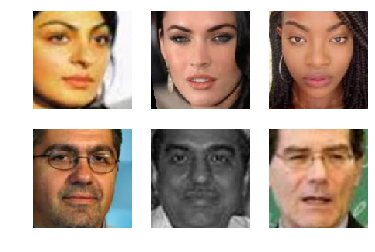

In [0]:
from numpy import load
from matplotlib import pyplot
# load the dataset
data = load('/content/drive/My Drive/EIP3/session7/utkface_128.npz')
dataA, dataB = data['arr_0'], data['arr_1']
print('Loaded: ', dataA.shape, dataB.shape)
# plot source images
n_samples = 3
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(dataA[i].astype('uint8'))
# plot target image
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + n_samples + i)
	pyplot.axis('off')
	pyplot.imshow(dataB[i].astype('uint8'))
pyplot.show()

#### install keras-contrib so that we can use InstanceNormalization instead of BatchNormalization

In [0]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git


  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-225cusg3
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-225cusg3
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101066 sha256=4c2686ed2595b2fbcc1fd6df0f014cb70df688e3b37ff72e3fb6ef31dd35e615
  Stored in directory: /tmp/pip-ephem-wheel-cache-rkeooafj/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [0]:
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.initializers import RandomNormal

#### define helper functions for the various components of the Model that we are going to build 

#### Conv layers 

In [0]:
def conv2d(input_, output_dim, ks=4, s=2, stddev=0.02, padding='SAME',name='c2d'):
  return Conv2D(output_dim,kernel_size=ks,strides=s,padding=padding,kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),name=name)(input_)

#### Leaky Relu

In [0]:
def lrelu(input_,name='lr'):
  return LeakyReLU(alpha=0.2,name=name)(input_)

#### InstanceNormalization 

In [0]:
def iNorm(input_,name='iNorm'):
  return InstanceNormalization(axis=-1,name=name)(input_)

###Discriminator Model 

In [0]:
# discriminator model
def build_discriminator(image_shape):
  # weight initialization
	#init = RandomNormal(stddev=0.02)
	# source image input
	in_image = Input(shape=image_shape)
	#C1
	d1 = lrelu(conv2d(in_image,64,4,name='d_c1'),'lr1' )
	 
	# C2
	d2 = lrelu(iNorm(conv2d(d1,128,4,name='d_c2'),'iN2'),'lr2') 
	
	# C3
	d3 = lrelu(iNorm(conv2d(d1,256,4,name='d_c3'),'iN3'),'lr3')
	
	# C4
	d4 = lrelu(iNorm(conv2d(d3,512,4,name='d_c4'),'iN4'),'lr4')
	
	'''
	# second last output layer
	d = conv2d(in_image,128,3,1) 
	d = iNorm(d)  
	d = lrelu(d) 
	'''

	#  output

	d5 = conv2d(d4,1,4,1,name='d_c5')  #Conv2D(1, 4,1, padding='same', kernel_initializer=init)(d)
	# define model
	model = Model(in_image, d5)
	# compile model
	model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])
	return model

In [0]:
disc=build_discriminator(dataB[0].shape)
disc.summary()

W0823 12:23:56.827917 140499755456384 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0823 12:23:56.872185 140499755456384 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0823 12:23:57.044422 140499755456384 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
d_c1 (Conv2D)                (None, 64, 64, 64)        3136      
_________________________________________________________________
lr1 (LeakyReLU)              (None, 64, 64, 64)        0         
_________________________________________________________________
d_c3 (Conv2D)                (None, 32, 32, 256)       262400    
_________________________________________________________________
iN3 (InstanceNormalization)  (None, 32, 32, 256)       512       
_________________________________________________________________
lr3 (LeakyReLU)              (None, 32, 32, 256)       0         
_________________________________________________________________
d_c4 (Conv2D)                (None, 16, 16, 512)       2097664   
__________

##### function to add padding 

In [0]:
def padd3(input_):
  import tensorflow as tf
  return tf.pad(input_, [[0, 0], [3, 3], [3, 3], [0, 0]], "REFLECT")

def padd1(input_):
  import tensorflow as tf
  return tf.pad(input_, [[0, 0], [1, 1], [1, 1], [0, 0]], "REFLECT")  

#### The generator uses Resnet Blocks , as defined below 

In [0]:
from keras.layers import Add,Lambda
def res_block(input_,nf=64,ks=3,s=1,name='res_blk'):
  p=int((ks-1)/2)
  y=Lambda(padd1)(input_) #(tf.pad(input_,[[0,0],[p,p],[p,p],[0,0]],'REFLECT'))
  
  y=iNorm(conv2d(y,nf,ks,s,padding='VALID',name=name+'_c1'),name=name+'_iN1')
  
  y=Lambda(padd1)(y) #(tf.pad(tf.nn.relu(y),[[0,0],[p,p],[p,p],[0,0]],'REFLECT'))
  
  y=iNorm(conv2d(y,nf,ks,s,padding='VALID',name=name+'_c2'),name=name+'_iN2')
  
  
  y1=keras.layers.Add()([y,input_])
  
  return y1

#### deconvolution layers 

In [0]:
def deconv2d(input_, output_dim, ks=4, s=2, stddev=0.02, padding='SAME',name='dc2d'):
  #Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
  
  dcv=Conv2DTranspose(output_dim,(ks,ks),strides=(s,s),padding=padding,kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),name=name)(input_)
  
  return dcv

#### generator model 

In [0]:
from keras.layers import Lambda,Conv2DTranspose

def build_generator(image_shape):
  nf=64 # num filters for first layer 
  input_=Input(shape=(128,128,3))
  c0 = Lambda(padd3)(input_)
  
  c1 = Activation('relu')(iNorm(conv2d(c0, nf, 7, 1, padding='VALID', name='g_e1_c'), 'g_e1_bn'))
  c2 = Activation('relu')(iNorm(conv2d(c1, nf*2, 3, 2, name='g_e2_c'), 'g_e2_bn'))
  c3 = Activation('relu')(iNorm(conv2d(c2, nf*4 , 3, 2, name='g_e3_c'), 'g_e3_bn'))

  r1 = res_block(c3, nf*4, name='g_r1')
  r2 = res_block(r1, nf*4, name='g_r2')
  r3 = res_block(r2, nf*4, name='g_r3')
  r4 = res_block(r3, nf*4, name='g_r4')
  r5 = res_block(r4, nf*4, name='g_r5')
  r6 = res_block(r5, nf*4, name='g_r6')
  r7 = res_block(r6, nf*4, name='g_r7')
  r8 = res_block(r7, nf*4, name='g_r8')
  r9 = res_block(r8, nf*4, name='g_r9')
  
  
  d1=Conv2DTranspose(nf*2, (3,3), strides=(2,2), padding='same', kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),name='g_d1_dc')(r9)
  
  d1=Activation('relu')(iNorm(d1,name='g_d1_bn'))

  d2=Conv2DTranspose(nf, (3,3), strides=(2,2), padding='same', kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),name='g_d2_dc')(d1)
  

  d2=Activation('relu')(iNorm(d2,name='g_d2_bn'))

  d2 = Lambda(padd3)(d2)#(tf.pad(d2, [[0, 0], [3, 3], [3, 3], [0, 0]], "REFLECT"))

  

  d3=conv2d(d2, 3 , 7, 1, padding='VALID', name='g_pred_c')

  

  pred=Activation('tanh')(d3)

  model=Model(input_,pred)
  

  return model








In [0]:
gen=build_generator(dataA[0].shape)
gen.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_20 (Lambda)              (None, 134, 134, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
g_e1_c (Conv2D)                 (None, 128, 128, 64) 9472        lambda_20[0][0]                  
__________________________________________________________________________________________________
g_e1_bn (InstanceNormalization) (None, 128, 128, 64) 128         g_e1_c[0][0]                     
__________________________________________________________________________________________________
activation

####composite Model with two genartors and discriminator 

In [0]:
def build_composite_model(g_model_1, d_model, g_model_2, image_shape):
	# ensure the model we're updating is trainable
	g_model_1.trainable = True
	# mark discriminator as not trainable
	d_model.trainable = False
	# mark other generator model as not trainable
	g_model_2.trainable = False
	# discriminator element
	input_gen = Input(shape=image_shape)
	gen1_out = g_model_1(input_gen)
	output_d = d_model(gen1_out)
	# identity element
	input_id = Input(shape=image_shape)
	output_id = g_model_1(input_id)
	# forward cycle
	output_f = g_model_2(gen1_out)
	# backward cycle
	gen2_out = g_model_2(input_id)
	output_b = g_model_1(gen2_out)
	# define model graph
	model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
	# define optimization algorithm configuration
	opt = Adam(lr=0.0002, beta_1=0.5)
	# compile model with weighting of least squares loss and L1 loss
	model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=opt)
	return model

### The original samples are over 3100 per domain and it is increasing the time for each epoch(has proven problematic in the initial training runs). So we will use a function to get a subsample of the training data , 1000 per Domain  

In [0]:
def get_subsample(dataset):

    t1=np.random.randint(900)
    t2=np.random.randint(1200,2000)
    t3=np.random.randint(2500,2800)
    return np.vstack((dataset[0][t1:t1+300],dataset[0][t2:t2+400],dataset[0][t3:t3+300])),np.vstack((dataset[1][t1:t1+300], dataset[1][t2:t2+400],dataset[1][t3:t3+300]))
 
 

In [0]:
def get_subsample2(dataset):
  t0=np.random.randint(250)
  t1=np.random.randint(300)
  t2=np.random.randint(1200,2000)
  t3=np.random.randint(2500,2800)
  return np.vstack((dataset[0][t1:t1+800],dataset[0][t2:t2+200])),np.vstack((dataset[1][t1:t1+100], dataset[2][t0:t0+900]))
 

#### Utility Functions to load the image samples , generate fake images , save Models , Save genrated images , etc

In [0]:
def load_real_samples2(filename):
  data = load(filename)
  X1,X2,X3 = data['arr_0'],data['arr_1'],data['arr_2']
  X1= (X1-127.5)/127.5
  X2 = (X2-127.5)/127.5
  X3 = (X3-127.5)/127.5
  return X1,X2,X3

In [0]:
# load and prepare training images
def load_real_samples(filename):
	# load the dataset
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]
 
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return X, y
 
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, dataset, patch_shape):
	# generate fake instance
	X = g_model.predict(dataset)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y
 
# save the generator models to file
def save_models(step, g_model_AtoB, g_model_BtoA):
	# save the first generator model
	filename1 = '/content/drive/My Drive/EIP3/session7/g_model_AtoB_%06d.h5' % (step+1)
	g_model_AtoB.save(filename1)
	# save the second generator model
	filename2 = '/content/drive/My Drive/EIP3/session7/g_model_BtoA_%06d.h5' % (step+1)
	g_model_BtoA.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))
  
# save the generator models to file
def save_models2(step, g_model_AtoB, g_model_BtoA,d_model_A,d_model_B):
	# save the first generator model
	filename1 = '/content/drive/My Drive/EIP3/session7/g_model_AtoB_%06d.h5' % (step+1)
	g_model_AtoB.save(filename1)
	# save the second generator model
	filename2 = '/content/drive/My Drive/EIP3/session7/g_model_BtoA_%06d.h5' % (step+1)
	g_model_BtoA.save(filename2)
  # save the first discriminator model A
	filename3 = '/content/drive/My Drive/EIP3/session7/d_model_A_%06d.h5' % (step+1)
	d_model_A.save(filename3)
  # save the first discriminator model B
	filename4 = '/content/drive/My Drive/EIP3/session7/d_model_B_%06d.h5' % (step+1)
	d_model_B.save(filename4)
	print('>Saved: %s , %s , %s and %s' % (filename1, filename2,filename3,filename4))  
  

In [0]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, trainX, name, n_samples=5):

	pyplot.figure(
    figsize=(15, 8),
    dpi=120)
 
	# select a sample of input images
	X_in, _ = generate_real_samples(trainX, n_samples, 0)
	# generate translated images
	X_out, _ = generate_fake_samples(g_model, X_in, 0)
	# scale all pixels from [-1,1] to [0,1]
	X_in = (X_in + 1) / 2.0
	X_out = (X_out + 1) / 2.0
	# plot real images
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_in[i])
	# plot translated image
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_out[i])
	# save plot to file
	filename1 = '/content/drive/My Drive/EIP3/session7/%s_generated_plot_%06d.png' % (name, (step+1))
	pyplot.savefig(filename1)
	pyplot.close()

#### Maintain a pool of 50 images as described in the paper 

In [0]:
# update image pool for fake images
def update_image_pool(pool, images, max_size=50):
	selected = list()
	for image in images:
		if len(pool) < max_size:
			# stock the pool
			pool.append(image)
			selected.append(image)
		elif random() < 0.5:
			# use image, but don't add it to the pool
			selected.append(image)
		else:
			# replace an existing image and use replaced image
			ix = randint(0, len(pool))
			selected.append(pool[ix])
			pool[ix] = image
	return asarray(selected)

#### function to run the training 

In [0]:
# train cyclegan models
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset,batch_size,n_epochs):
	# define properties of the training run
	n_epochs, n_batch, = n_epochs, batch_size
	# determine the output square shape of the discriminator
	n_patch = d_model_A.output_shape[1]
	# unpack dataset
	trainA, trainB = get_subsample(dataset)
	# prepare image pool for fakes
	poolA, poolB = list(), list()
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
		X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
		X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
		# update fakes from pool
		X_fakeA = update_image_pool(poolA, X_fakeA)
		X_fakeB = update_image_pool(poolB, X_fakeB)
		# update generator B->A via adversarial and cycle loss
		g_loss2, _, _, _, _  = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
		# update discriminator for A -> [real/fake]
		dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
		dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
		# update generator A->B via adversarial and cycle loss
		g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
		# update discriminator for B -> [real/fake]
		dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
		dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
		# summarize performance
		print('>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))
		# evaluate the model performance every so often
		if (i+1) % (bat_per_epo * 1) == 0:
			# plot A->B translation
			summarize_performance(i, g_model_AtoB, trainA, 'AtoB')
			# plot B->A translation
			summarize_performance(i, g_model_BtoA, trainB, 'BtoA')
		if (i+1) % (bat_per_epo * 5) == 0:
			# save the models
			save_models2(i, g_model_AtoB, g_model_BtoA,d_model_A,d_model_B)

#### define the models and run training 

In [0]:
from random import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randint
from keras.optimizers import Adam
# load image data
dataset = load_real_samples('/content/drive/My Drive/EIP3/session7/utkface_128.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# generator: A -> B
g_model_AtoB = build_generator(image_shape)
# generator: B -> A
g_model_BtoA = build_generator(image_shape)
# discriminator: A -> [real/fake]
d_model_A = build_discriminator(image_shape)
# discriminator: B -> [real/fake]
d_model_B = build_discriminator(image_shape)
# composite: A -> B -> [real/fake, A]
c_model_AtoB = build_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# composite: B -> A -> [real/fake, B]
c_model_BtoA = build_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)
# train models
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset,batch_size=2,n_epochs=10)

Loaded (2000, 128, 128, 3) (2000, 128, 128, 3)


W0823 12:27:07.819926 140499755456384 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:2741: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0823 12:27:07.823910 140499755456384 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0823 12:27:07.826261 140499755456384 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected train

>1, dA[0.635,0.880] dB[1.139,0.556] g[14.853,15.097]
>2, dA[6.329,1.425] dB[9.205,0.589] g[14.410,15.497]
>3, dA[0.775,0.742] dB[1.710,0.713] g[13.737,14.006]
>4, dA[2.266,0.553] dB[0.734,1.243] g[13.985,13.497]
>5, dA[1.135,0.407] dB[0.324,0.670] g[11.458,12.143]
>6, dA[0.296,0.367] dB[0.267,0.476] g[11.143,11.300]
>7, dA[0.221,0.373] dB[0.242,0.366] g[10.246,10.563]
>8, dA[0.191,0.384] dB[0.207,0.315] g[9.175,9.515]
>9, dA[0.208,0.317] dB[0.197,0.263] g[8.072,8.302]
>10, dA[0.192,0.254] dB[0.199,0.282] g[7.750,7.687]
>11, dA[0.178,0.233] dB[0.213,0.354] g[7.174,6.859]
>12, dA[0.171,0.238] dB[0.388,0.390] g[8.321,7.281]
>13, dA[0.174,0.230] dB[0.408,0.313] g[9.137,8.059]
>14, dA[0.170,0.224] dB[0.457,0.319] g[8.287,7.548]
>15, dA[0.175,0.214] dB[0.367,0.260] g[7.764,6.887]
>16, dA[0.206,0.202] dB[0.305,0.209] g[8.295,7.740]
>17, dA[0.216,0.201] dB[0.231,0.218] g[7.099,6.969]
>18, dA[0.212,0.181] dB[0.194,0.201] g[7.661,7.627]
>19, dA[0.182,0.195] dB[0.218,0.194] g[7.555,7.465]
>20, dA

In [0]:

# load image data
dataset = load_real_samples('/content/drive/My Drive/EIP3/session7/utkface_128.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]

#load the previously trained model 

cust = {'InstanceNormalization': InstanceNormalization, 'tf': tf}
# generator: A -> B
g_model_AtoB = load_model('/content/drive/My Drive/EIP3/session7/g_model_AtoB_005625.h5', cust)
# generator: B -> A
g_model_BtoA = load_model('/content/drive/My Drive/EIP3/session7/g_model_BtoA_005625.h5', cust)
 
# discriminator: A -> [real/fake]
d_model_A = build_discriminator(image_shape)
# discriminator: B -> [real/fake]
d_model_B = build_discriminator(image_shape)
# composite: A -> B -> [real/fake, A]
c_model_AtoB = build_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# composite: B -> A -> [real/fake, B]
c_model_BtoA = build_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)

###Run time disconnected and session ended , so load last saved models and continue training . Increase the batch size and reduce the sample size too with get_subsample utility function 

In [0]:
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset,batch_size=24,n_epochs=5)

In [0]:
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset,batch_size=24,n_epochs=5)

In [0]:
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset,batch_size=24,n_epochs=5)

In [0]:
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset,batch_size=24,n_epochs=10)

In [0]:
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset,batch_size=24,n_epochs=10)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, dA[0.143,0.168] dB[0.150,0.115] g[2.206,2.275]
>2, dA[0.120,0.133] dB[0.145,0.134] g[2.204,2.362]
>3, dA[0.146,0.131] dB[0.121,0.136] g[2.178,2.684]
>4, dA[0.114,0.109] dB[0.123,0.127] g[2.114,2.399]
>5, dA[0.159,0.150] dB[0.138,0.142] g[2.180,2.587]
>6, dA[0.136,0.123] dB[0.167,0.125] g[2.135,2.343]
>7, dA[0.136,0.131] dB[0.135,0.140] g[1.930,2.049]
>8, dA[0.129,0.156] dB[0.146,0.119] g[2.208,2.361]
>9, dA[0.161,0.122] dB[0.135,0.140] g[2.028,2.235]
>10, dA[0.159,0.166] dB[0.125,0.125] g[1.981,2.239]
>11, dA[0.149,0.112] dB[0.128,0.143] g[1.935,2.166]
>12, dA[0.127,0.131] dB[0.139,0.139] g[2.118,2.532]
>13, dA[0.136,0.146] dB[0.123,0.133] g[2.114,2.561]
>14, dA[0.111,0.129] dB[0.167,0.115] g[2.190,2.316]
>15, dA[0.120,0.122] dB[0.155,0.144] g[2.162,2.647]
>16, dA[0.159,0.126] dB[0.110,0.130] g[1.939,2.340]
>17, dA[0.129,0.113] dB[0.115,0.126] g[2.040,2.253]
>18, dA[0.107,0.135] dB[0.132,0.133] g[2.395,2.537]
>19, dA[0.109,0.100] dB[0.128,0.101] g[2.490,2.606]
>20, dA[0.139,0.120] 

In [0]:
# load image data
dataset = load_real_samples2('/content/drive/My Drive/EIP3/session7/utkface_128_2.npz')

In [0]:
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset,batch_size=24,n_epochs=20)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, dA[0.134,0.126] dB[0.134,0.131] g[2.387,2.563]
>2, dA[0.115,0.123] dB[0.130,0.110] g[2.599,2.608]
>3, dA[0.130,0.118] dB[0.105,0.121] g[2.479,2.709]
>4, dA[0.150,0.118] dB[0.120,0.137] g[2.545,2.867]
>5, dA[0.109,0.110] dB[0.136,0.117] g[2.356,2.592]
>6, dA[0.082,0.114] dB[0.150,0.142] g[2.587,2.634]
>7, dA[0.137,0.129] dB[0.181,0.161] g[2.457,2.714]
>8, dA[0.114,0.116] dB[0.126,0.143] g[2.585,2.921]
>9, dA[0.112,0.123] dB[0.139,0.119] g[2.451,2.628]
>10, dA[0.138,0.109] dB[0.142,0.153] g[2.410,2.881]
>11, dA[0.173,0.173] dB[0.133,0.139] g[2.315,2.763]
>12, dA[0.095,0.104] dB[0.142,0.101] g[2.443,2.484]
>13, dA[0.142,0.129] dB[0.144,0.152] g[2.252,2.677]
>14, dA[0.098,0.140] dB[0.128,0.137] g[2.380,2.463]
>15, dA[0.143,0.106] dB[0.147,0.099] g[2.686,2.686]
>16, dA[0.156,0.156] dB[0.148,0.136] g[2.701,2.831]
>17, dA[0.162,0.126] dB[0.130,0.155] g[2.291,2.747]
>18, dA[0.103,0.116] dB[0.134,0.139] g[2.376,2.582]
>19, dA[0.125,0.105] dB[0.133,0.112] g[2.565,3.146]
>20, dA[0.110,0.174] 

In [0]:
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset,batch_size=24,n_epochs=20)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, dA[0.125,0.168] dB[0.142,0.149] g[2.358,2.556]
>2, dA[0.136,0.097] dB[0.108,0.123] g[2.478,2.828]
>3, dA[0.131,0.138] dB[0.128,0.116] g[2.605,3.074]
>4, dA[0.132,0.131] dB[0.130,0.115] g[2.524,2.739]
>5, dA[0.120,0.110] dB[0.139,0.146] g[2.623,3.250]
>6, dA[0.119,0.149] dB[0.154,0.139] g[2.584,2.883]
>7, dA[0.114,0.114] dB[0.163,0.127] g[2.518,2.829]
>8, dA[0.136,0.161] dB[0.123,0.133] g[2.223,2.523]
>9, dA[0.170,0.170] dB[0.120,0.134] g[2.326,2.452]
>10, dA[0.162,0.143] dB[0.123,0.105] g[2.497,2.679]
>11, dA[0.106,0.151] dB[0.138,0.105] g[2.647,2.708]
>12, dA[0.139,0.131] dB[0.131,0.129] g[2.314,2.535]
>13, dA[0.127,0.124] dB[0.121,0.143] g[2.374,2.648]
>14, dA[0.143,0.107] dB[0.144,0.136] g[2.476,2.671]
>15, dA[0.130,0.145] dB[0.164,0.134] g[2.424,2.584]
>16, dA[0.138,0.127] dB[0.105,0.143] g[2.306,2.583]
>17, dA[0.129,0.117] dB[0.139,0.133] g[2.688,2.888]
>18, dA[0.134,0.130] dB[0.146,0.124] g[2.372,2.542]
>19, dA[0.129,0.129] dB[0.129,0.127] g[2.326,2.463]
>20, dA[0.115,0.086] 

In [0]:
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset,batch_size=24,n_epochs=20)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, dA[0.104,0.132] dB[0.142,0.123] g[2.244,2.342]
>2, dA[0.104,0.097] dB[0.117,0.098] g[2.299,2.535]
>3, dA[0.137,0.091] dB[0.136,0.117] g[2.288,2.781]
>4, dA[0.113,0.098] dB[0.107,0.112] g[2.150,2.502]
>5, dA[0.077,0.077] dB[0.128,0.115] g[2.220,2.427]
>6, dA[0.082,0.104] dB[0.148,0.123] g[2.097,2.240]
>7, dA[0.129,0.067] dB[0.061,0.134] g[2.049,2.638]
>8, dA[0.085,0.145] dB[0.159,0.099] g[2.422,2.262]
>9, dA[0.116,0.122] dB[0.116,0.111] g[2.356,2.538]
>10, dA[0.122,0.115] dB[0.126,0.103] g[2.213,2.581]
>11, dA[0.149,0.118] dB[0.118,0.138] g[2.133,2.730]
>12, dA[0.118,0.127] dB[0.138,0.129] g[2.196,2.686]
>13, dA[0.097,0.101] dB[0.104,0.118] g[2.449,2.554]
>14, dA[0.132,0.126] dB[0.118,0.111] g[2.467,2.769]
>15, dA[0.103,0.083] dB[0.106,0.090] g[2.461,2.703]
>16, dA[0.096,0.096] dB[0.139,0.124] g[2.310,2.851]
>17, dA[0.131,0.081] dB[0.085,0.085] g[2.129,2.574]
>18, dA[0.073,0.086] dB[0.137,0.123] g[2.500,3.084]
>19, dA[0.069,0.075] dB[0.131,0.113] g[2.256,2.458]
>20, dA[0.101,0.080] 

In [0]:
# load image data
dataset = load_real_samples('/content/drive/My Drive/EIP3/session7/utkface_128.npz')

In [0]:
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset,batch_size=24,n_epochs=10)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, dA[0.123,0.080] dB[0.084,0.100] g[2.224,2.672]
>2, dA[0.089,0.109] dB[0.124,0.100] g[2.203,2.519]
>3, dA[0.099,0.082] dB[0.112,0.100] g[2.188,2.636]
>4, dA[0.068,0.197] dB[0.124,0.129] g[2.211,2.400]
>5, dA[0.381,0.561] dB[0.110,0.108] g[2.238,2.767]
>6, dA[1.393,2.299] dB[0.120,0.094] g[2.358,4.547]
>7, dA[12.804,8.431] dB[0.121,0.114] g[5.125,30.683]
>8, dA[4.939,0.298] dB[0.101,0.112] g[6.319,10.708]
>9, dA[0.544,0.398] dB[0.092,0.120] g[5.321,8.236]
>10, dA[0.243,0.213] dB[0.139,0.112] g[4.831,5.670]
>11, dA[0.187,0.188] dB[0.167,0.203] g[4.799,5.128]
>12, dA[0.230,0.154] dB[0.210,0.167] g[4.660,4.878]
>13, dA[0.203,0.183] dB[0.133,0.137] g[3.795,4.405]
>14, dA[0.174,0.158] dB[0.114,0.123] g[3.461,3.978]
>15, dA[0.157,0.171] dB[0.116,0.118] g[3.773,4.368]
>16, dA[0.171,0.167] dB[0.105,0.113] g[3.586,3.969]
>17, dA[0.173,0.171] dB[0.113,0.103] g[3.338,3.811]
>18, dA[0.179,0.159] dB[0.135,0.107] g[3.387,3.641]
>19, dA[0.159,0.157] dB[0.112,0.093] g[3.668,3.835]
>20, dA[0.154,0.15

In [0]:
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset,batch_size=24,n_epochs=1)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, dA[0.146,0.147] dB[0.157,0.137] g[2.610,2.781]
>2, dA[0.161,0.114] dB[0.119,0.125] g[2.385,2.581]
>3, dA[0.142,0.154] dB[0.147,0.098] g[2.268,2.111]
>4, dA[0.149,0.158] dB[0.174,0.164] g[2.114,2.079]
>5, dA[0.148,0.145] dB[0.114,0.127] g[2.098,2.132]
>6, dA[0.149,0.168] dB[0.140,0.144] g[2.245,2.269]
>7, dA[0.148,0.124] dB[0.161,0.170] g[2.245,2.154]
>8, dA[0.151,0.149] dB[0.207,0.187] g[2.132,2.122]
>9, dA[0.161,0.152] dB[0.178,0.184] g[2.112,2.288]
>10, dA[0.157,0.153] dB[0.180,0.136] g[2.272,2.283]
>11, dA[0.148,0.148] dB[0.138,0.146] g[2.349,2.365]
>12, dA[0.151,0.140] dB[0.152,0.153] g[2.033,2.068]
>13, dA[0.161,0.148] dB[0.149,0.136] g[2.025,2.017]
>14, dA[0.178,0.144] dB[0.149,0.146] g[1.951,2.028]
>15, dA[0.123,0.152] dB[0.138,0.136] g[2.112,2.118]
>16, dA[0.146,0.133] dB[0.140,0.126] g[2.037,2.227]
>17, dA[0.137,0.141] dB[0.163,0.121] g[2.103,1.987]
>18, dA[0.144,0.121] dB[0.096,0.117] g[2.046,2.296]
>19, dA[0.126,0.157] dB[0.128,0.110] g[2.031,2.135]
>20, dA[0.150,0.143] 

#### We have trained the model for slighly over 100 epochs . Although more epochs will give better results, we stop here due to time constraints . We will try out the results of this training 

In [0]:
def show_results( g_model, trainX, n_samples=5,title='A to B'):
  pyplot.figure(
    figsize=(12, 6),
    dpi=120)
  # select a sample of input images
  X_in, _ = generate_real_samples(trainX, n_samples, 0)
	# generate translated images
  X_out, _ = generate_fake_samples(g_model, X_in, 0)
	# scale all pixels from [-1,1] to [0,1]
  X_in = (X_in + 1) / 2.0
  X_out = (X_out + 1) / 2.0
	# plot real images
  #pyplot.title(title)
  for i in range(n_samples):
    pyplot.subplot(2, n_samples, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(X_in[i])
  pyplot.show()
  print("      ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ "+title+" ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓")
	# plot translated image
  pyplot.figure(
    figsize=(12, 6),
    dpi=120)
  for i in range(n_samples):
    pyplot.subplot(2, n_samples, 1 + n_samples + i)
    pyplot.axis('off')
    pyplot.imshow(X_out[i])
  pyplot.show()

  
  

## domain A to Domain B generation results : Young to Old

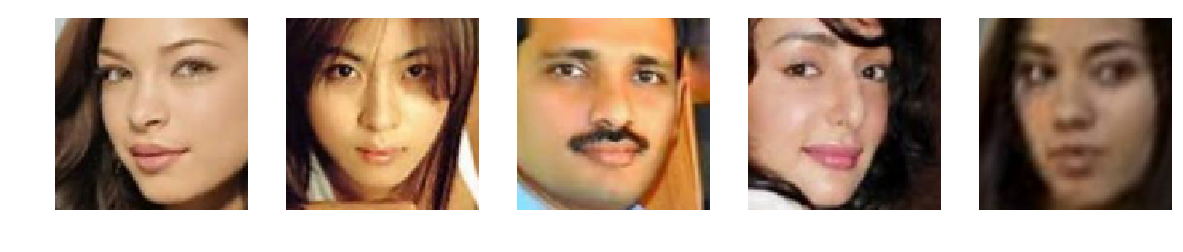

      ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ YOUNG TO OLD ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓


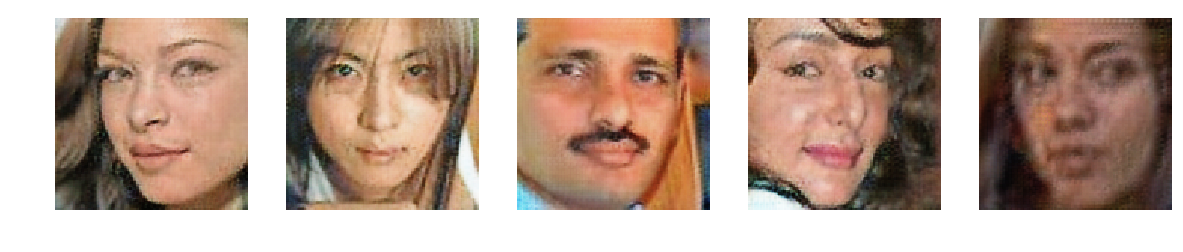

In [0]:
trainA, trainB = dataset
show_results(g_model_AtoB, trainA, 5, 'YOUNG TO OLD')

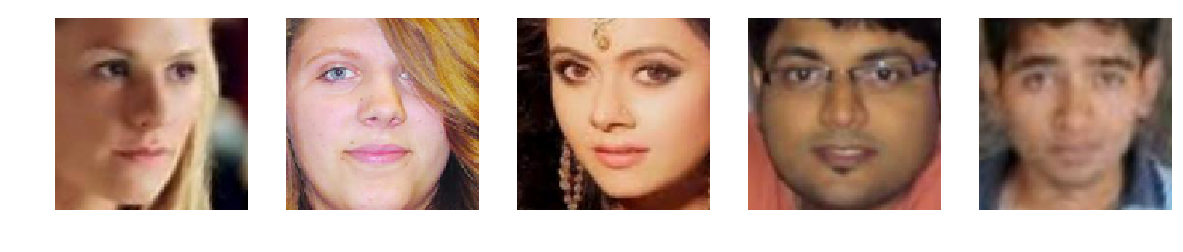

      ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ YOUNG TO OLD ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓


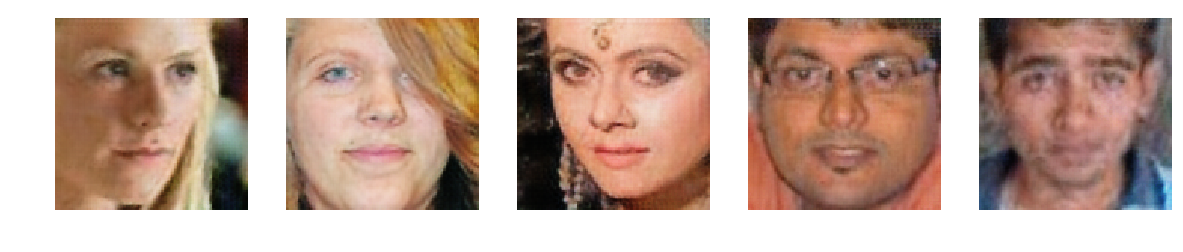

In [0]:
show_results(g_model_AtoB, trainA, 5, 'YOUNG TO OLD')

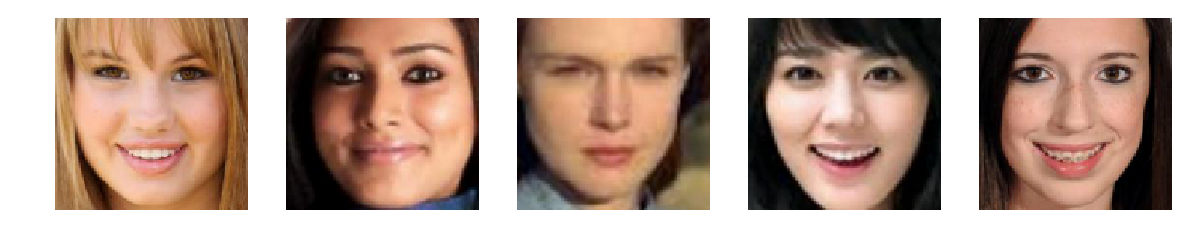

      ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ YOUNG TO OLD ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓


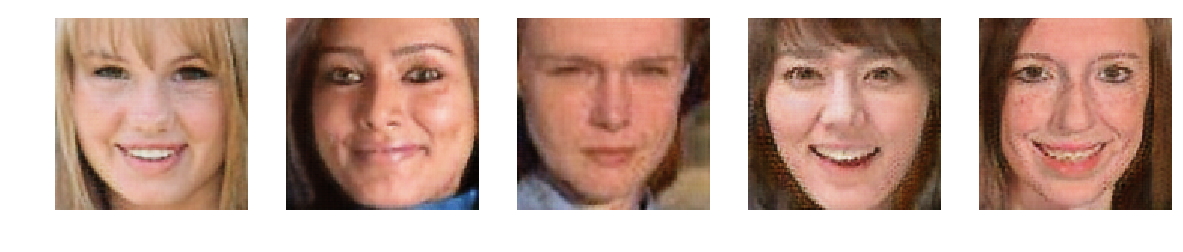

In [0]:
show_results(g_model_AtoB, trainA, 5, 'YOUNG TO OLD')

## domain B to Domain A generation results : Old to Young

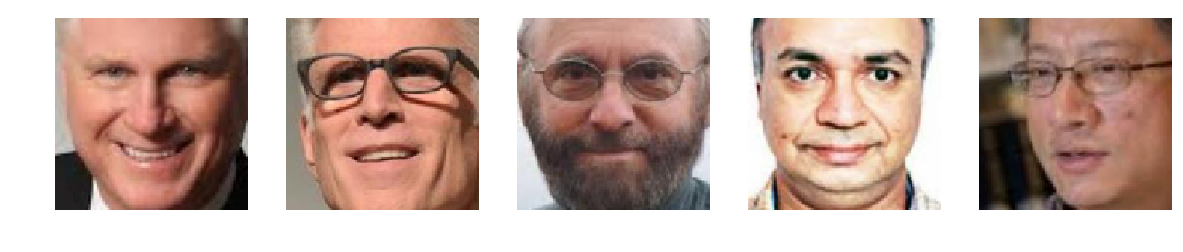

      ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓  Old to Young  ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓


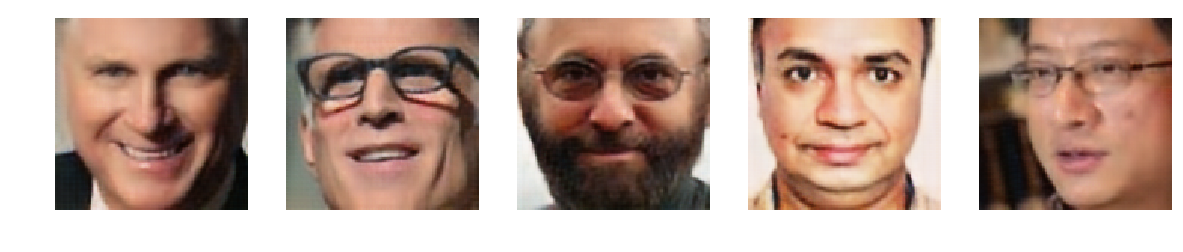

In [0]:
show_results(g_model_BtoA, trainB ,5, ' Old to Young ')

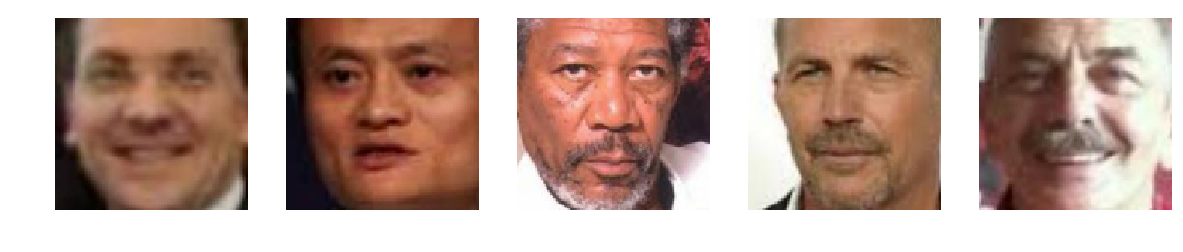

      ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓  Old to Young  ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓


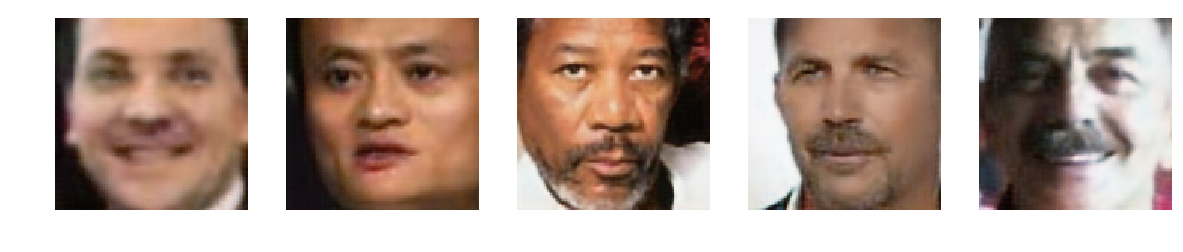

In [0]:
show_results(g_model_BtoA, trainB ,5, ' Old to Young ')

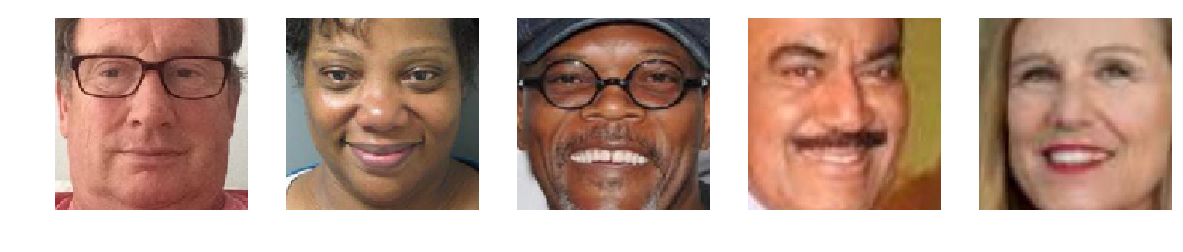

      ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓  Old to Young  ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓


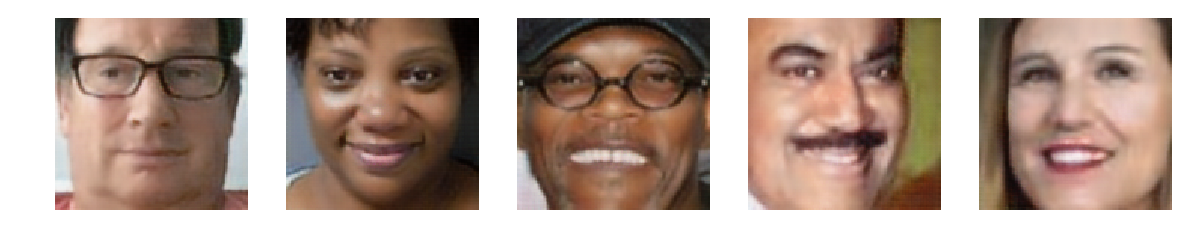

In [0]:
show_results(g_model_BtoA, trainB ,5, ' Old to Young ')

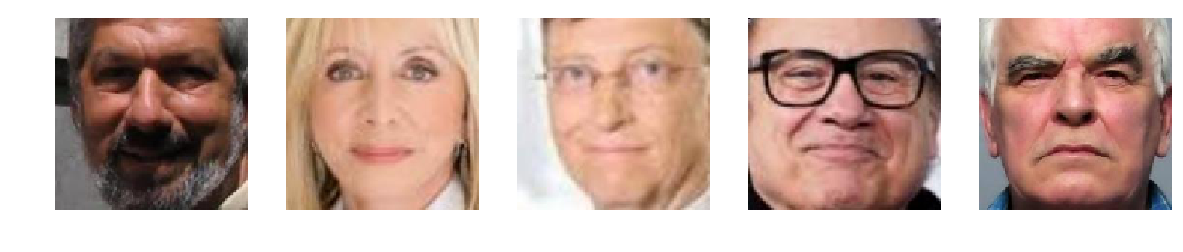

      ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓  Old to Young  ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓


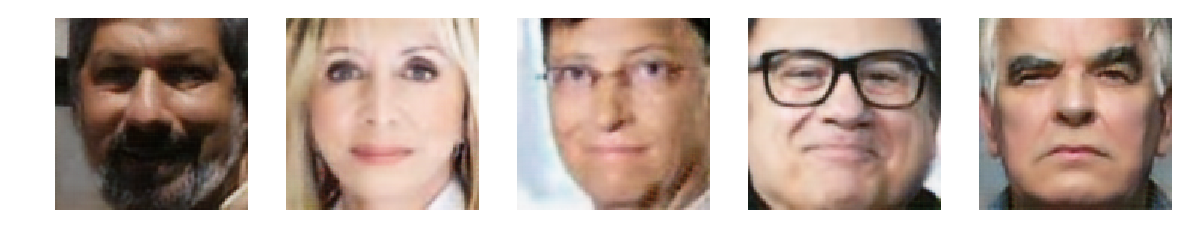

In [0]:
show_results(g_model_BtoA, trainB ,5, ' Old to Young ')

#### Training the models for more epochs will make the results better, especially for Young to Old Translation . Also we used 128x128 images due to time and compute constraints . Training on the original 200x200 image size would have yielded better results 